In [1]:
from datasets import list_datasets, load_dataset
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
# datasets_list = list_datasets() 
# print(datasets_list) 

In [3]:
empathetic_dialogue_dataset = load_dataset('empathetic_dialogues')  

Found cached dataset empathetic_dialogues (/home/ahmed_b/.cache/huggingface/datasets/empathetic_dialogues/default/0.1.0/09bbeed3882a67db98c73952fb3c1c9a85af83dc78f81454c2454382fd03f6cf)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train_df = empathetic_dialogue_dataset["train"].to_pandas()
val_df = empathetic_dialogue_dataset["validation"].to_pandas()
test_df = empathetic_dialogue_dataset["test"].to_pandas()
all_df = pd.concat([train_df, val_df, test_df])
sample_df = all_df.iloc[:1000]

In [5]:
df = all_df
#df = sample_df
len(df)

99646

## Preparing Electra classifier

In [6]:
from typing import Optional
import os

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics
from transformers import ElectraModel, ElectraPreTrainedModel, ElectraTokenizerFast as ElectraTokenizer, AdamW
from transformers.models.electra.modeling_electra import ElectraClassificationHead

from transformers import ElectraTokenizerFast as ElectraTokenizer

import torch
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

%matplotlib inline 
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette (sns.color_palette (HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(42)

Global seed set to 42


42

In [7]:
class ElectraClassifier(ElectraPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.n_classes = config.num_labels
    self.config = config
    self.electra = ElectraModel(config)
    self.classifier = ElectraClassificationHead(config)

    self.post_init()

  def forward(
      self,
      input_ids=None,
      attention_mask=None
  ):
    discriminator_hidden_states = self.electra(input_ids, attention_mask)
    sequence_output = discriminator_hidden_states[0]
    logits = self.classifier(sequence_output)
    return logits

class EmotionClassifier(pl.LightningModule):
  def __init__(self, n_classes, learning_rate: Optional[float]=None):
    super().__init__()
    self.n_classes = n_classes
    self.classifier = ElectraClassifier.from_pretrained(
        "google/electra-base-discriminator",
        #"google/electra-base-discriminator",
        num_labels=n_classes
    )
    self.criterion = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

  def forward(self, input_ids, attention_mask):
    return self.classifier(input_ids, attention_mask)

  def run_step(self, batch, stage):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"].long()
    logits = self(input_ids, attention_mask)

    loss = self.criterion(logits, labels)
    self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    return loss

  def training_step(self, batch, batch_idx):
    return self.run_step(batch, "train")

  def validation_step(self, batch, batch_idx):
    return self.run_step(batch, "val")

  def test_step(self, batch, batch_idx):
    return self.run_step(batch, "test")

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.learning_rate)

In [8]:
best_model_path = "electra_cls/lightning_logs/version_18/checkpoints/epoch=9-step=3629.ckpt"
emotion_categories = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral']

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

In [9]:
trained_model = EmotionClassifier.load_from_checkpoint(
    # trainer.checkpoint_callback.best_model_path,
    best_model_path,
    n_classes=len(emotion_categories)
)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_pr

In [10]:
def Predict_emotion(text, top_k=3):
  encoding = tokenizer(
          text,
          max_length=64, 
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
  # outputs = trained_model(encoding["input_ids"], encoding["attention_mask"])
  outputs = trained_model(**encoding)
  probabilities = list(torch.softmax(outputs, dim=-1).detach().numpy().flatten())
  emotion_idx = torch.argmax(outputs, dim=-1).item() 
  predicted_emotion = emotion_categories[emotion_idx]

  emotion_categories_list = list(emotion_categories)
  probabilities, emotion_categories_list = zip(*sorted(zip(probabilities, emotion_categories_list)))
  probabilities = probabilities[::-1]
  emotion_categories_list = emotion_categories_list[::-1]

  print(f'The sentence "{sample_text}"')
  print(f"Expresses the {predicted_emotion.upper()} emotion ({100*probabilities[0]:.0f}%).")

  print("\n-- Other probabilities: --\n")
  k = 1
  for label, probability in zip(list(emotion_categories_list), list(probabilities)):
    print(f"P({label}) = {100*probability:.2f}%.")
    k += 1
    if k > top_k: 
      break

In [11]:
sample_text = "Don't talk to me like that!."
Predict_emotion(sample_text)

The sentence "Don't talk to me like that!."
Expresses the ANGER emotion (88%).

-- Other probabilities: --

P(anger) = 88.39%.
P(annoyance) = 9.78%.
P(disapproval) = 1.34%.


In [12]:
def label_with_electra(text):
    encoding = tokenizer(
          text,
          max_length=64, 
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
    # outputs = trained_model(encoding["input_ids"], encoding["attention_mask"])
    outputs = trained_model(**encoding)
    emotion_idx = torch.argmax(outputs, dim=-1).item() 
    #predicted_emotion = emotion_categories[emotion_idx]
    return emotion_idx

In [13]:
# sample_df["electra_emotion"] = sample_df["prompt"].progress_apply(lambda x: label_with_electra(x))

In [14]:
df["electra_emotion"] = df["utterance"].progress_apply(lambda x: label_with_electra(x))

  0%|          | 0/99646 [00:00<?, ?it/s]

In [ ]:
df.to_pickle("ed_with_electra_emotions_df")

In [21]:
df.head()

conv_id  utterance_idx      context  \
0  hit:0_conv:1              1  sentimental   
1  hit:0_conv:1              2  sentimental   
2  hit:0_conv:1              3  sentimental   
3  hit:0_conv:1              4  sentimental   
4  hit:0_conv:1              5  sentimental   

                                              prompt  speaker_idx  \
0  I remember going to the fireworks with my best...            1   
1  I remember going to the fireworks with my best...            0   
2  I remember going to the fireworks with my best...            1   
3  I remember going to the fireworks with my best...            0   
4  I remember going to the fireworks with my best...            1   

                                           utterance     selfeval tags  \
0  I remember going to see the fireworks with my ...  5|5|5_2|2|5        
1  Was this a friend you were in love with_comma_...  5|5|5_2|2|5        
2                This was a best friend. I miss her.  5|5|5_2|2|5        
3                                Where has she gone?  5|5|5_2|2|5        
4                                 We no longer talk.  5|5|5_2|2|5        

   electra_emotion  
0               17  
1                7  
2               25  
3                7  
4               27

In [23]:
df.electra_emotion.value_counts()

27    183
7     116
0      98
4      85
17     47
13     38
14     36
20     34
15     33
1      33
25     31
9      30
3      25
10     23
5      22
18     22
8      19
26     19
6      19
22     16
24     16
2      14
12     13
11      8
19      8
23      5
21      4
16      3
Name: electra_emotion, dtype: int64

In [22]:
reformed_all_df = df.groupby("conv_id")["electra_emotion"].apply(list).to_frame().reset_index()
reformed_all_df.head()

conv_id        electra_emotion
0      hit:0_conv:1  [17, 7, 25, 7, 27, 7]
1  hit:100_conv:200     [25, 24, 4, 25, 0]
2  hit:100_conv:201        [19, 14, 0, 17]
3  hit:101_conv:202       [4, 7, 0, 1, 17]
4  hit:101_conv:203       [14, 10, 20, 27]

In [16]:
def extract_emotion_chain(emotion_list, number_of_emotions = 7):
    emotions_chain = dict()
    for i in range(number_of_emotions):
        emotions_chain ["emotions_following_" + str(i)] = []

    old_emotion_number = 0
    for list_index, emotion_number in enumerate(emotion_list):
        if list_index > 0:
            emotions_chain["emotions_following_" + str(int(old_emotion_number))].append(emotion_number)
            old_emotion_number = emotion_number
    return emotions_chain

In [17]:
reformed_all_df["electra_emotion_chain"] = reformed_all_df["electra_emotion"].apply(lambda x: extract_emotion_chain(x, len(emotion_categories)))
reformed_all_df.head()

conv_id        electra_emotion  \
0          hit:0_conv:0      [14, 7, 24, 7, 9]   
1          hit:0_conv:1  [17, 7, 25, 7, 27, 7]   
2  hit:10000_conv:20000         [18, 7, 17, 0]   
3  hit:10000_conv:20001          [0, 0, 27, 4]   
4  hit:10001_conv:20002           [3, 9, 9, 7]   

                               electra_emotion_chain  
0  {'emotions_following_0': [7], 'emotions_follow...  
1  {'emotions_following_0': [7], 'emotions_follow...  
2  {'emotions_following_0': [7], 'emotions_follow...  
3  {'emotions_following_0': [0, 27], 'emotions_fo...  
4  {'emotions_following_0': [9], 'emotions_follow...

In [18]:
electra_emotion_chain_df = pd.concat([pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in reformed_all_df.iloc[i]["electra_emotion_chain"].items() ])) for i in range(len(reformed_all_df))])
electra_emotion_chain_df.head()

/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


emotions_following_0  emotions_following_1  emotions_following_2  \
0                   7.0                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   7.0                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   7.0                   NaN                   NaN   

   emotions_following_3  emotions_following_4  emotions_following_5  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   

   emotions_following_6  emotions_following_7  emotions_following_8  \
0                   NaN                  24.0                   NaN   
1                   NaN                   9.0                   NaN   
0                   NaN                  25.0                   NaN   
1                   NaN                  27.0                   NaN   
0                   NaN                  17.0                   NaN   

   emotions_following_9  ...  emotions_following_18  emotions_following_19  \
0                   NaN  ...                    NaN                    NaN   
1                   NaN  ...                    NaN                    NaN   
0                   NaN  ...                    NaN                    NaN   
1                   NaN  ...                    NaN                    NaN   
0                   NaN  ...                    NaN                    NaN   

   emotions_following_20  emotions_following_21  emotions_following_22  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   

   emotions_following_23  emotions_following_24  emotions_following_25  \
0                    NaN                    7.0                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    7.0   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   

   emotions_following_26  emotions_following_27  
0                    NaN                    NaN  
1                    NaN                    NaN  
0                    NaN                    7.0  
1                    NaN                    NaN  
0                    NaN                    NaN  

[5 rows x 28 columns]

In [24]:
emotion_categories = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Tot = 28
Cols = 2
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)

xticks = []
xticks.extend(range(len(emotion_categories)))

fig = plt.figure(figsize=(30, 200))
for k in tqdm(range(Tot)):
    ax = fig.add_subplot(Rows,Cols,Position[k])
    sns.histplot(electra_emotion_chain_df['emotions_following_'+str(k)], bins=xticks, ax=ax, binwidth=0.4)
    ax.xaxis.set_ticks(xticks)
    ax.set_xticklabels(emotion_categories, rotation = 70)
    ax.set_xlabel("Emotions following " + emotion_categories[k])

plt.show()

  0%|          | 0/28 [00:00<?, ?it/s]

In [23]:
electra_emotion_chain_df.head()

emotions_following_0  emotions_following_1  emotions_following_2  \
0                   7.0                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   7.0                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   7.0                   NaN                   NaN   

   emotions_following_3  emotions_following_4  emotions_following_5  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   

   emotions_following_6  emotions_following_7  emotions_following_8  \
0                   NaN                  24.0                   NaN   
1                   NaN                   9.0                   NaN   
0                   NaN                  25.0                   NaN   
1                   NaN                  27.0                   NaN   
0                   NaN                  17.0                   NaN   

   emotions_following_9  ...  emotions_following_18  emotions_following_19  \
0                   NaN  ...                    NaN                    NaN   
1                   NaN  ...                    NaN                    NaN   
0                   NaN  ...                    NaN                    NaN   
1                   NaN  ...                    NaN                    NaN   
0                   NaN  ...                    NaN                    NaN   

   emotions_following_20  emotions_following_21  emotions_following_22  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   

   emotions_following_23  emotions_following_24  emotions_following_25  \
0                    NaN                    7.0                    NaN   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    7.0   
1                    NaN                    NaN                    NaN   
0                    NaN                    NaN                    NaN   

   emotions_following_26  emotions_following_27  
0                    NaN                    NaN  
1                    NaN                    NaN  
0                    NaN                    7.0  
1                    NaN                    NaN  
0                    NaN                    NaN  

[5 rows x 28 columns]

In [67]:
def show_the_most_following_emotion(data_chain):
    most_common_following_emotions = []
    for idx, emotion in enumerate(emotion_categories):
        most_common_following_emotion_idx = data_chain["emotions_following_"+str(idx)].value_counts().idxmax()
        most_common_following_emotion = emotion_categories[int(most_common_following_emotion_idx)]
        most_common_following_emotions.append(most_common_following_emotion)
    most_common_df = pd.DataFrame(list(zip(emotion_categories, most_common_following_emotions)),
                                  columns =['Initial emotion', 'Mostly followed by'])
    return most_common_df   

In [68]:
show_the_most_following_emotion(electra_emotion_chain_df)

Initial emotion Mostly followed by
0       admiration          curiosity
1        amusement            neutral
2            anger            neutral
3        annoyance            neutral
4         approval         admiration
5           caring            neutral
6        confusion            neutral
7        curiosity            neutral
8           desire            neutral
9   disappointment            neutral
10     disapproval            neutral
11         disgust            neutral
12   embarrassment            neutral
13      excitement         admiration
14            fear            neutral
15       gratitude         admiration
16           grief            remorse
17             joy         admiration
18            love         admiration
19     nervousness            neutral
20        optimism            neutral
21           pride         admiration
22     realization            neutral
23          relief         admiration
24         remorse            neutral
25         sadness            neutral
26        surprise            neutral
27         neutral            neutral

In [70]:
def show_the_most_following_emotion_without_neutral(data_chain):
    most_common_following_emotions = []
    for idx, emotion in enumerate(emotion_categories):
        if data_chain["emotions_following_"+str(idx)].value_counts().idxmax() != 27:
            most_common_following_emotion_idx = data_chain["emotions_following_"+str(idx)].value_counts().idxmax()
        else:
            most_common_following_emotion_idx = data_chain["emotions_following_"+str(idx)].value_counts().index[1]
        most_common_following_emotion = emotion_categories[int(most_common_following_emotion_idx)]
        most_common_following_emotions.append(most_common_following_emotion)
    most_common_df = pd.DataFrame(list(zip(emotion_categories, most_common_following_emotions)),
                                  columns =['Initial emotion', 'Mostly followed by'])
    return most_common_df   

In [71]:
show_the_most_following_emotion_without_neutral(electra_emotion_chain_df)

Initial emotion Mostly followed by
0       admiration          curiosity
1        amusement          amusement
2            anger           approval
3        annoyance           approval
4         approval         admiration
5           caring          gratitude
6        confusion           approval
7        curiosity           approval
8           desire         admiration
9   disappointment           approval
10     disapproval           approval
11         disgust           approval
12   embarrassment           approval
13      excitement         admiration
14            fear               fear
15       gratitude         admiration
16           grief            remorse
17             joy         admiration
18            love         admiration
19     nervousness           approval
20        optimism           approval
21           pride         admiration
22     realization           approval
23          relief         admiration
24         remorse           approval
25         sadness           approval
26        surprise         admiration
27         neutral         admiration

  0%|          | 0/28 [00:00<?, ?it/s]

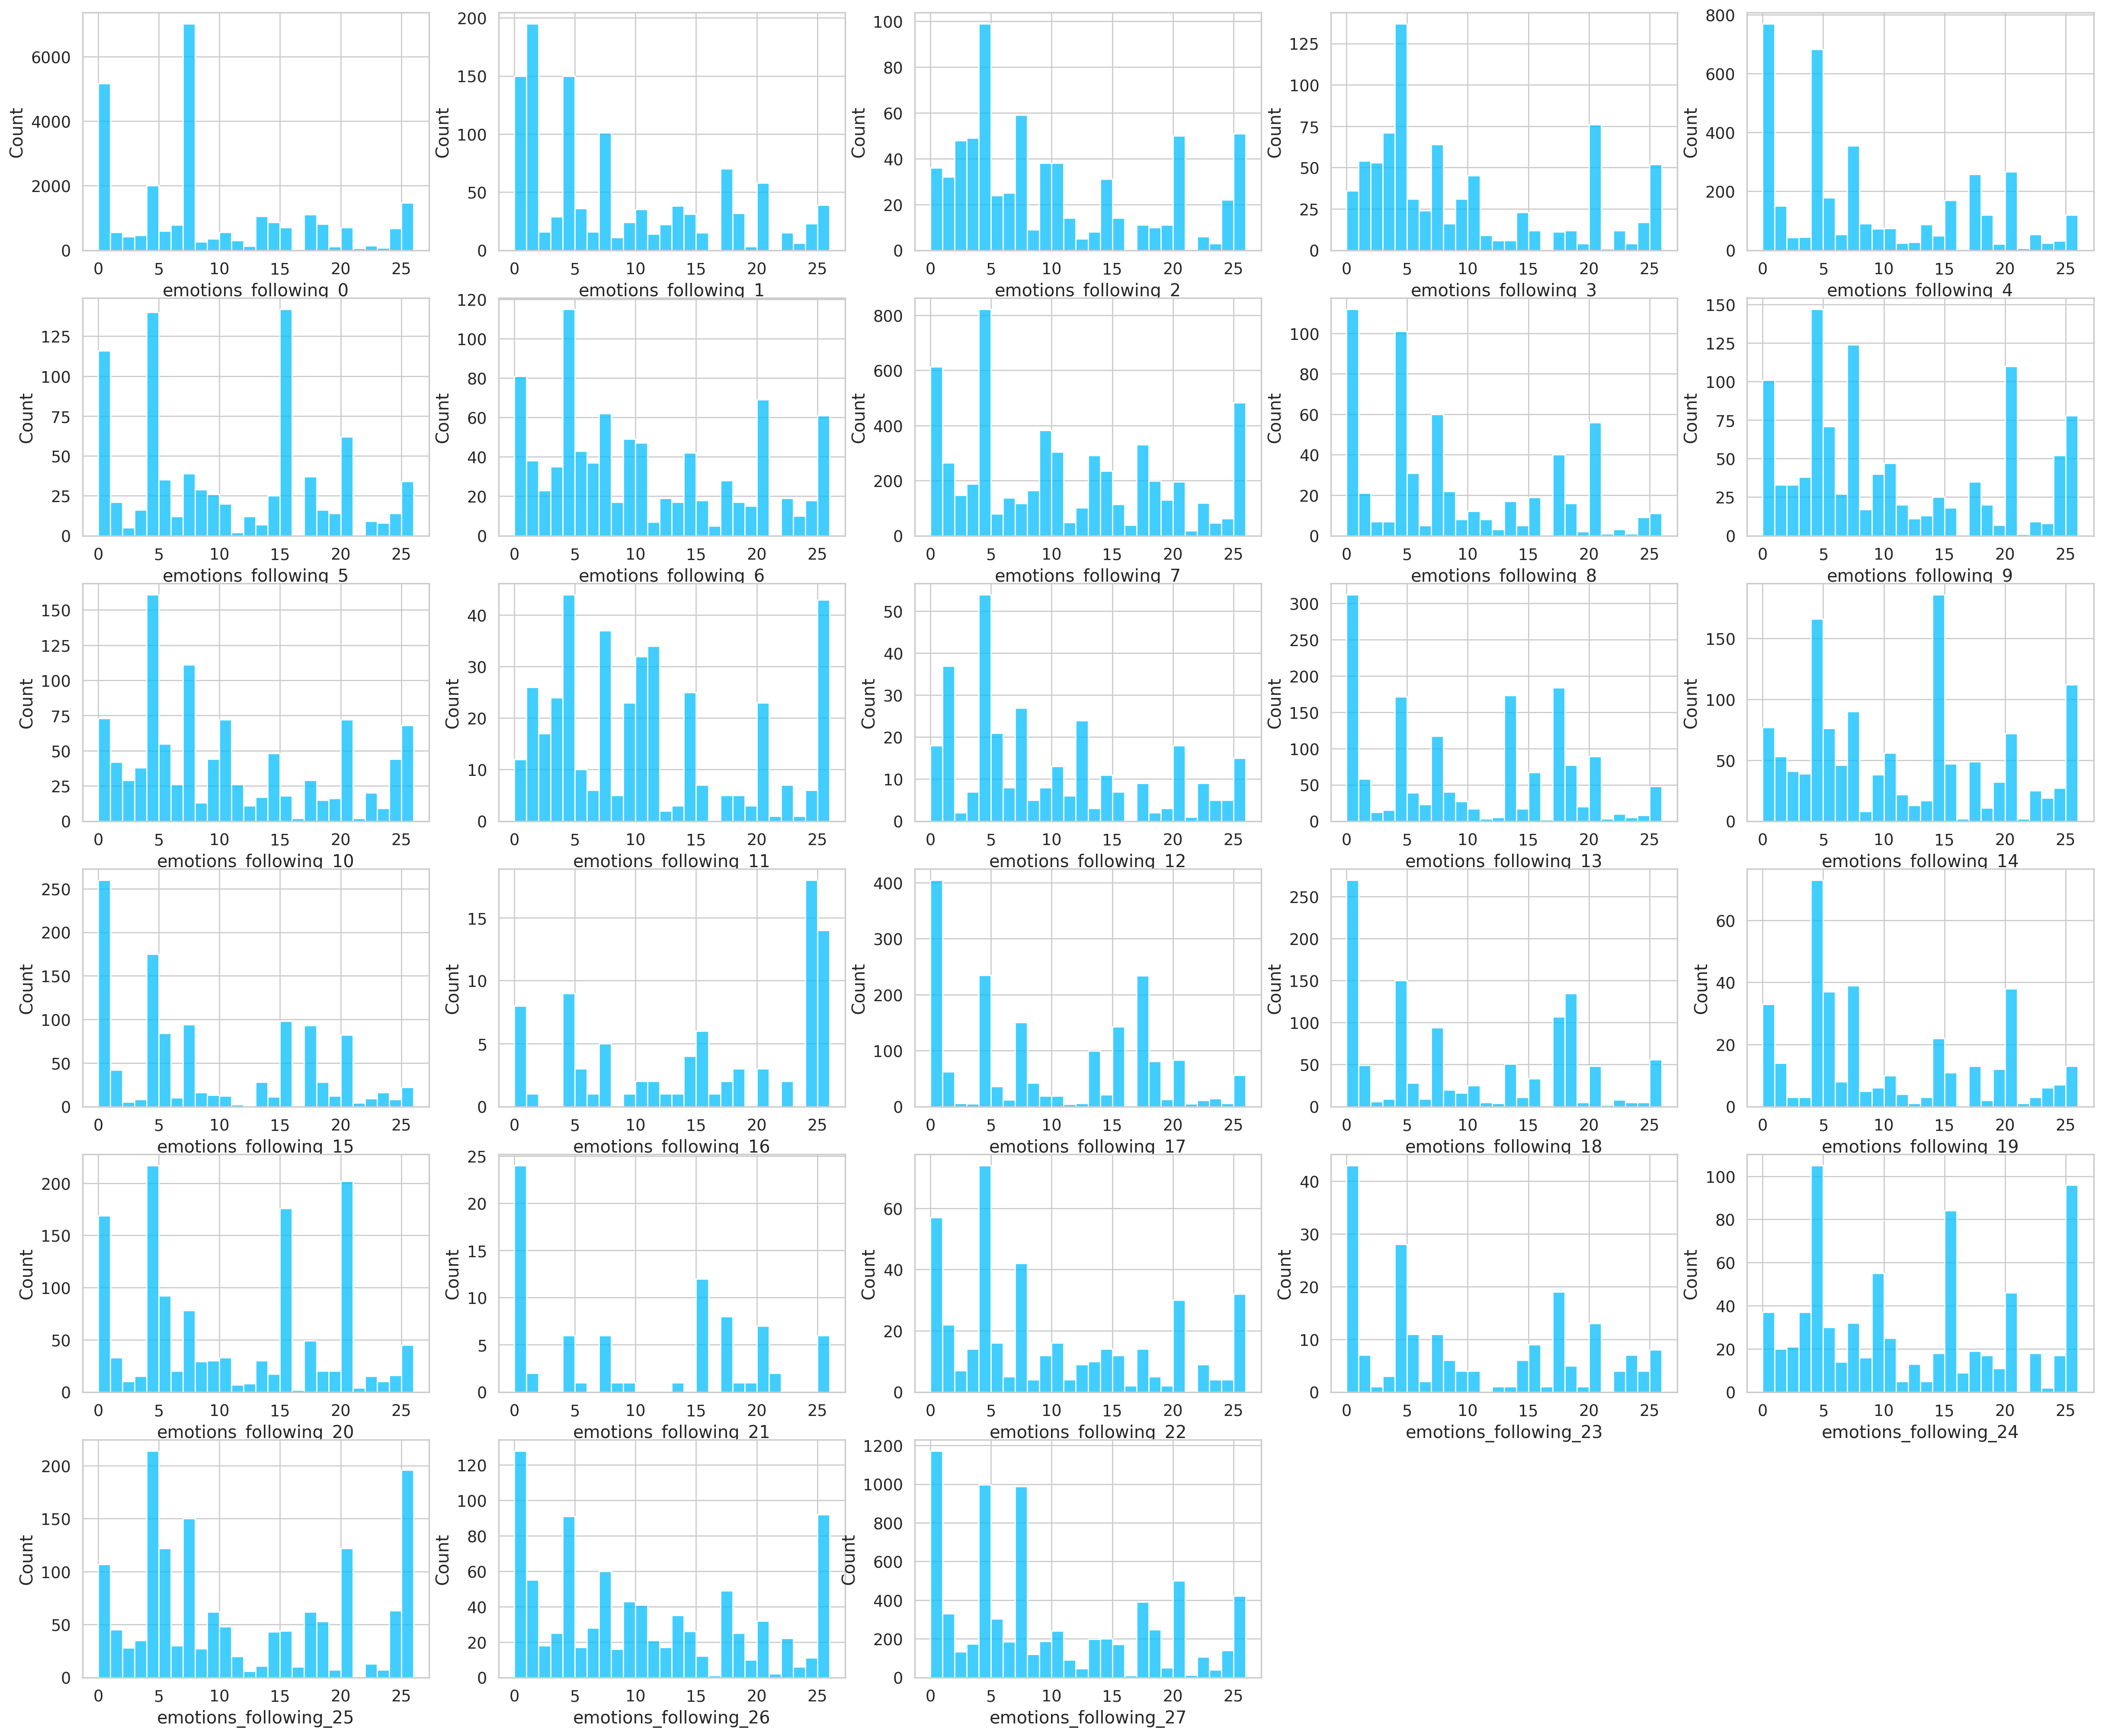

In [19]:
Tot = 28
Cols = 5
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)

xlabels = []
xlabels.extend(range(len(emotion_categories)-1))

fig = plt.figure(figsize=(30, 25))
for k in tqdm(range(Tot)):
    ax = fig.add_subplot(Rows,Cols,Position[k])
    sns.histplot(electra_emotion_chain_df['emotions_following_'+str(k)], bins=xlabels, ax=ax)
plt.show()

## Saving resulting dataframes

In [20]:
electra_emotion_chain_df.to_pickle("ED_electra_emotion_chain_df")
emotion_chain_df.to_pickle("ED_emotion_chain_df")
all_df.to_pickle("ED_all_df")

NameError: name 'emotion_chain_df' is not defined

In [ ]:
sample_df.head()

In [ ]:
sample_df.electra_emotion.value_counts()

In [ ]:
emotion_categories[25]

In [ ]:
sample_df[["utterance", "electra_emotion"]].iloc[20]

In [ ]:
sample_utterance = sample_df.iloc[34].utterance
sample_utterance

In [ ]:
emotion_categories[label_with_electra(sample_utterance)]

In [ ]:
emotion_categories[17]

In [ ]:
pd.DataFrame(sample_df.prompt, sample_df.electra_emotion)

In [ ]:
sample_df.prompt

In [ ]:
sample_df = all_df.iloc[:100]
sample_df.head()

In [ ]:
all_df.utterance_idx.value_counts()

In [ ]:
all_df[all_df['utterance'].str.startswith("I have been hearing")]

In [ ]:
all_df[all_df.conv_id == "hit:2750_conv:5501"]

In [ ]:
all_df.iloc[17136].utterance

In [ ]:
sample_df.groupby("conv_id").count()

In [ ]:
sample_df.iloc[0]